In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import ast
import matplotlib.pyplot as plt
from datetime import timedelta
from shapely.geometry import shape, Point
import json
from preview import *

In [ ]:
plume_flaring = pd.read_csv("Plume_Flaring_Evaluation_2017-2025.csv")
plume_flaring["granule_date"] = pd.to_datetime(plume_flaring["system_index"].str[:8], format="%Y%m%d", errors="coerce")
plume_flaring = plume_flaring[plume_flaring['cloud_fraction']<10]
plume_flaring['flare_latlon'] = plume_flaring['flare_latlon'].apply(ast.literal_eval)
plume_flaring = plume_flaring[plume_flaring['flare_latlon'].apply(lambda x : len(x) != 0 )]
plume_flaring['flare_latlon'] = plume_flaring['flare_latlon'].apply(lambda c: Point(c[0],c[1]) if isinstance(c[0],float) else Point(c[0][0],c[0][1]))
plume_flaring["geometry"] = plume_flaring[".geo"].apply(lambda x: shape(json.loads(x)))
plume_flaring_gdf = gpd.GeoDataFrame(plume_flaring, geometry="geometry", crs="EPSG:4326")  # assuming lat/lon
plume_flaring_gdf['flare_latlon_meters'] = gpd.GeoSeries(plume_flaring_gdf["flare_latlon"], crs="EPSG:4326").to_crs(3857)
plume_flaring_gdf = assign_group_ids(plume_flaring_gdf)
plume_flaring_gdf['note'] = ""

C:\Users\ebeva\AppData\Local\Temp\ipykernel_21012\2586818532.py:163: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["buffer"] = gdf[geom_col].buffer(buffer_size)


In [6]:
granule_start = plume_flaring_gdf.groupby('structure_id').apply(lambda g:g[g['structure_present']==1]['granule_date'].min().date())
granule_end = plume_flaring_gdf.groupby('structure_id').apply(lambda g:g[g['structure_present']==1]['granule_date'].max().date())

# gfw_start = plume_flaring_gdf.groupby('structure_id').apply(lambda g: g.iloc[0]['structure_start_date'].date())
# gfw_end = plume_flaring_gdf.groupby('structure_id').apply(lambda g: g.iloc[0]['structure_end_date'].date())

total_counts = plume_flaring_gdf.groupby("structure_id").size()
flare_counts = plume_flaring_gdf[plume_flaring_gdf["flare_present"] > 0].groupby("structure_id").size()
present_counts = plume_flaring_gdf[plume_flaring_gdf["structure_present"] > 0].groupby("structure_id").size()

summary = pd.DataFrame({
    "total": total_counts,
    "flare_count": flare_counts,
    "present_count": present_counts,
    # "starting_presence": granule_start,
    # "ending_presence": granule_end,
    # "gfw_start": gfw_start,
    # "gfw_end": gfw_end,
}).fillna(0)  # fill NaN where no matches

# compute percentages
summary["flare_percent"] = (summary["flare_count"] / summary["total"]) * 100
summary["present_percent"] = (summary["present_count"] / summary["total"]) * 100
summary["flare%_of_present"] = (summary["flare_count"] / summary["present_count"]) * 100


C:\Users\ebeva\AppData\Local\Temp\ipykernel_21012\1133879599.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  granule_start = plume_flaring_gdf.groupby('structure_id').apply(lambda g:g[g['structure_present']==1]['granule_date'].min().date())
C:\Users\ebeva\AppData\Local\Temp\ipykernel_21012\1133879599.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  granule_end = plume_flaring_gdf.groupby('structure_id').apply(

In [7]:
summary = summary[summary['present_percent']>10]
summary = summary[summary['flare%_of_present']>10]
# summary

Flaring lat/lon analysis

In [8]:
TAI_cutoff = .5

In [9]:
# Make sure your gdf has a CRS
# If flare_latlon is just geometries, assign WGS84 (EPSG:4326) if not already
gdf_m = plume_flaring_gdf.set_geometry("flare_latlon_meters")
gdf_m["x"] = gdf_m.geometry.x
gdf_m["y"] = gdf_m.geometry.y

# Group by structure_id and compute mean and std in meters
stats = gdf_m[gdf_m['max_TAI']>=TAI_cutoff].groupby("structure_id").agg(
# stats = gdf_m[gdf_m['flare_present']==1].groupby("structure_id").agg(
    mean_x=("x", "mean"),
    mean_y=("y", "mean"),
    std_x=("x", "std"),
    std_y=("y", "std"),
    count=("x", "size"),
).reset_index()

# Convert mean_x, mean_y back to lat/lon for interpretation
flare_centroids = gpd.GeoDataFrame(
    stats,
    geometry=gpd.points_from_xy(stats["mean_x"], stats["mean_y"], crs="EPSG:3857"),
)
flare_centroids = flare_centroids.to_crs("EPSG:4326")  # back to lat/lon

# Add lat/lon columns
flare_centroids["mean_lat"] = flare_centroids.geometry.y
flare_centroids["mean_lon"] = flare_centroids.geometry.x

flaring_centroid_merged = plume_flaring_gdf.merge(
    flare_centroids.to_crs(3857)[["structure_id", "geometry"]],
    on="structure_id",
    how="left",
    suffixes=("", "_flare_centroid")
)
# Now compute distance (meters) between point and centroid
flaring_centroid_merged["dist_to_centroid"] = flaring_centroid_merged["flare_latlon_meters"].distance(flaring_centroid_merged["geometry_flare_centroid"])


In [10]:
summary.sort_values('flare_percent', ascending=False).head(5)

,total,flare_count,present_count,flare_percent,present_percent,flare%_of_present
structure_id,,,,,,
2,230,229,225,99.565217,97.826087,101.777778
3,228,226,210,99.122807,92.105263,107.619048
1,1169,780,923,66.723695,78.956373,84.507042


In [11]:
example_struct = 1

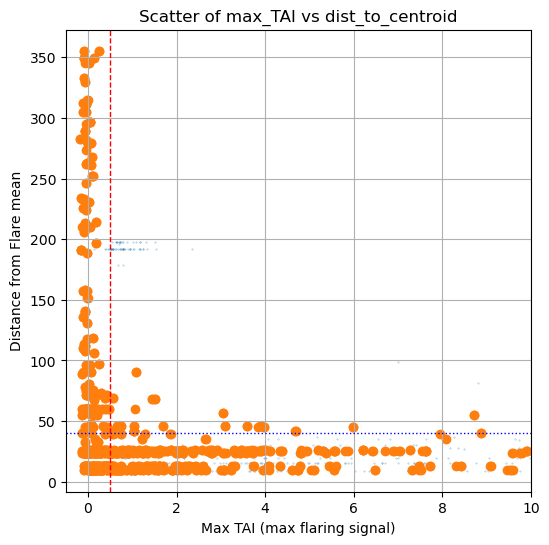

In [12]:
example_merged = flaring_centroid_merged[flaring_centroid_merged['structure_id']==example_struct]

plt.figure(figsize=(6,6))
plt.scatter(
    flaring_centroid_merged["max_TAI"],
    flaring_centroid_merged["dist_to_centroid"],
    alpha=0.5,
    s=0.1
)
plt.scatter(
    example_merged["max_TAI"],
    example_merged["dist_to_centroid"],
    alpha=1,
)

plt.xlabel("Max TAI (max flaring signal)")
plt.ylabel("Distance from Flare mean")
plt.title("Scatter of max_TAI vs dist_to_centroid")

# Set axis limits
plt.xlim(-.5, 10)
# plt.ylim(-1, 1)

# Add reference lines
plt.axvline(x=TAI_cutoff, color="red", linestyle="--", linewidth=1)
# plt.axhline(y=40, color="blue", linestyle="--", linewidth=1)
plt.axhline(y=40, color="blue", linestyle=":", linewidth=1)

plt.grid(True)
plt.show()


In [13]:
# flaring_centroid_merged.sort_values(by='dist_to_centroid')

c:\Users\ebeva\AppData\Local\anaconda3\envs\methane\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


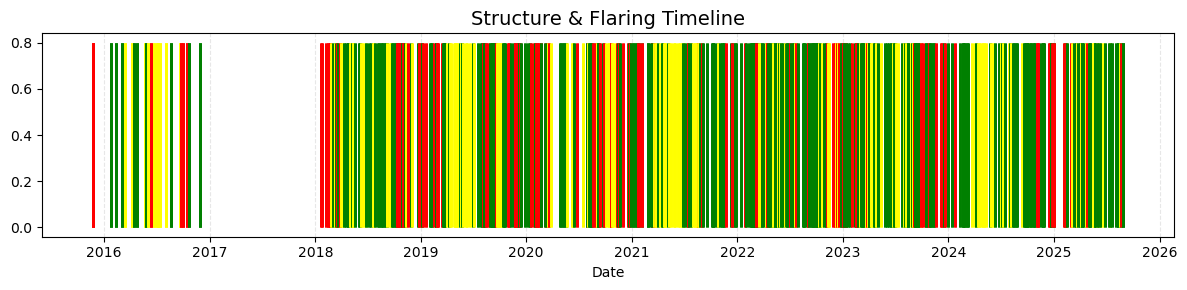

c:\Users\ebeva\AppData\Local\anaconda3\envs\methane\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


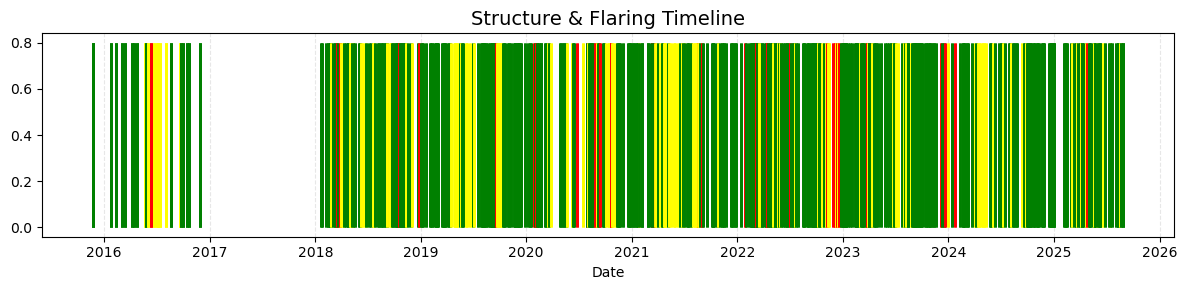

c:\Users\ebeva\AppData\Local\anaconda3\envs\methane\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


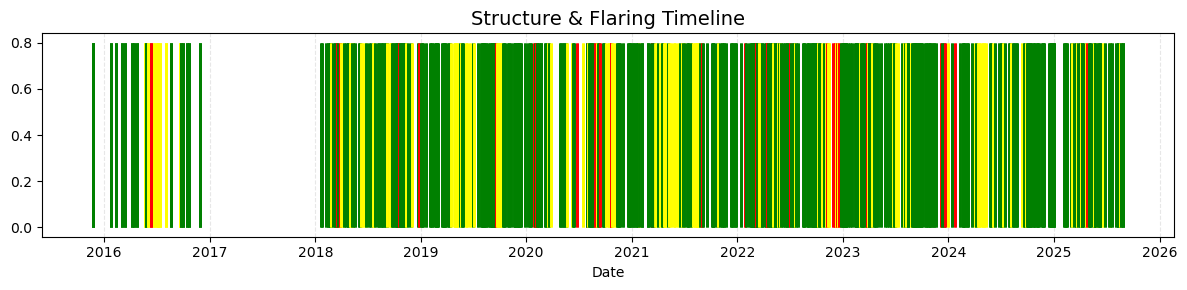

c:\Users\ebeva\AppData\Local\anaconda3\envs\methane\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


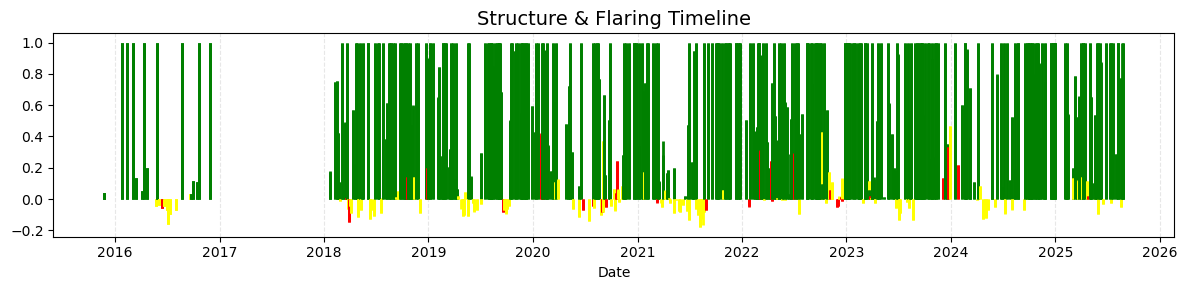

In [14]:
example_structure = flaring_centroid_merged[flaring_centroid_merged['structure_id'] == example_struct]
example_structure['flaring'] = example_structure['flare_present']
example_structure_timeline = create_structure_flaring_timeline(example_structure, flare_override_absent=False)
plot_structure_flaring_timeline(example_structure_timeline)

example_structure['flaring'] = ((example_structure['max_TAI'] > .01) & (example_structure['dist_to_centroid'] < 40) | (example_structure['max_TAI'] > .5))
example_structure_timeline = create_structure_flaring_timeline(example_structure)
plot_structure_flaring_timeline(example_structure_timeline)

example_structure['flaring'] = ((example_structure['max_TAI'] > .01) & (example_structure['dist_to_centroid'] < 40) | (example_structure['max_TAI'] > .5))
example_structure_timeline = create_structure_flaring_timeline(example_structure, filter_outlier = True)
plot_structure_flaring_timeline(example_structure_timeline)

example_structure['flaring'] = ((example_structure['max_TAI'] > .01) & (example_structure['dist_to_centroid'] < 40) | (example_structure['max_TAI'] > .5))
example_structure_timeline = create_structure_flaring_timeline(example_structure, filter_outlier = True)
plot_structure_flaring_timeline(example_structure_timeline, magnitude_col='max_TAI', max_mag=1)

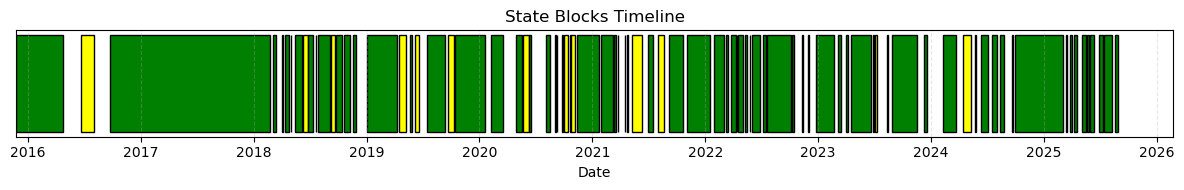

In [15]:
state_blocks = extract_state_blocks(example_structure_timeline)
plot_state_blocks(state_blocks)

In [98]:
# state_blocks[state_blocks['color']=='yellow']['granule_count'].sum()

In [15]:
# example_structure = plume_flaring_gdf[plume_flaring_gdf['structure_id'] == 137092]
# # example_structure = example_structure[example_structure['structure_present']==1]
# example_structure = example_structure[example_structure['flare_present']==1]
# example_structure = example_structure.sort_values(by = 'granule_date')
# flaring_centroid_merged

# example_structure = flaring_centroid_merged[flaring_centroid_merged['structure_id'] == 2]#.sort_values(by='granule_date', ascending= False)
# example_structure = flaring_centroid_merged.sort_values(by = 'dist_to_centroid')
# example_structure = example_structure[example_structure['max_TAI']>1]
# example_structure = example_structure[example_structure['dist_to_centroid']<50]

# example_structure

In [108]:
sid_data = gdf_to_sid_list(example_structure_timeline)
# bad_sid_data = add_glint_alpha(sid_data, collection="COPERNICUS/S2_SR_HARMONIZED")
sid_data = add_glint_alpha(sid_data)


In [ ]:
# bad_sid_pd = pd.DataFrame(bad_sid_data)
sid_pd = pd.DataFrame(sid_data)

# sid_pd_corrected = sid_pd[sid_pd['SID'].isin(bad_sid_pd[bad_sid_pd['glint_alpha'].isna()]['SID'].values)]
# sid_data = sid_pd_corrected.to_dict(orient='records')

In [146]:
sid_pd = sid_pd[sid_pd['SID'].apply(lambda x: x[31:]) == "_T15RXL"]
yellows = example_structure_timeline[example_structure_timeline['color'] == 'yellow']['system_index'].values
sid_data = sid_pd[sid_pd['SID'].isin(yellows)].to_dict(orient='records')

In [147]:

b11 = 3000
state = show_granule_viewer(
    sid_data,
    b11_b12_max=[b11, b11],
    zoom=16,
    mbsp_min_max=[-0.15, 0.15],
    extra_gdf=flare_centroids,
    starting_idx=0
    # extra_gdf=gfw_gdf,
)

In [20]:
# sid_data[190]

In [83]:
plume_flaring = pd.read_csv('pluming_infra_reviewed.csv')
# If state.sid is a single string:
plume_flaring.loc[plume_flaring['system_index'] == state.sid, 'note'] = 'plume found'
plume_flaring.to_csv('pluming_infra_reviewed.csv', index=False)

In [84]:
plume_flaring = pd.read_csv('pluming_infra_reviewed.csv')
plume_flaring[plume_flaring['system_index']==state.sid]

In [ ]:
len(plume_flaring[plume_flaring['note']=='plume found'])